# 오버피팅
- 오버피팅이란 
    - 신경망이 훈련 데이터에만 지나치게 적응되어, 그 외의 데이터에는 제대로 대응하지 못하는 상태를 말한다.
    - 기계학습은 범용적인 성능을 지향하기 때문에, 한 번도 보지 못한 데이터가 주어져도 바르게 식별해내는 모델이 바람직하다.
- 오버피팅의 원인
    - 매개변수가 많고 표현력이 높은 모델
    - 훈련 데이터가 적음

In [7]:
import os, sys
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅의 재현을 위해 학습 데이터 수를 임의로 줄인다.
x_train = x_train[:300]
t_train = t_train[:300]

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)
optimizer = SGD(lr=0.01) # 학습률이 0.01인  확률적 경사 하강법으로 매개변수 갱신
max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 에폭 단위의 정확도를 저장한다.
        test_acc_list.append(test_acc) # 에폭 단위의 정확도를 저장한다
        
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

<img src="./images/fig 6-20.png">

위처럼 훈련 데이터를 사용하여 측정한 정확도는 100 에폭을 지나는 무렵부터 거의 100%지만, 시험 데이터에 대해서는 큰 차이를 보인다.
이는 훈련 데이터에만 적응해버린 오버피팅의 결과이다.

# 오버피팅 억제
- 예로부터 많이 이용해온 방법중 하나는 가중치 감소(weight decay)라는 것이 있다.
    - 이는 학습 과정에서 큰 가중치에 대해서는 그에 상응하는 큰 패널티를 부과하여 오버피팅을 억제하는 방법이다.
    - 원래 오버피팅은 가중치 매개변수의 값이 커서 발생하는 경우가 많기 때문이다.
    
- 두 번째로 신경망 모델이 복잡해지면 가중치 감소만으로 대응하기 어려워, 이 때는 드롭아웃이라는 기법을 이용한다.
    - 드롭아웃은 뉴런을 임의로 삭제하며 학습하는 방법이다.
    - 훈련할 때 뉴런을 무작위로 골라 삭제한다.
    - 훈련 때는 데이터를 흘릴 때 마다 삭제할 뉴런을 무작위로 선택하고, 시험 때는 모든 뉴런에 신호를 전달한다.
    - 단, 시험 때는 각 뉴런의 출력에 훈련 떄 삭제한 비율을 곱하여 출력한다!

In [8]:
#드롭아웃의 구현
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio # x아 형상이 같이 배열을 무작위로 생성하고 
            # 그 값이 dropout_ratio보다 큰 원소만 True로 설정, 삭제될 뉴런은 False 처리
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
    
        
    def backward(self, dout):
        return dout * self.mask

- <img src="./images/fig 6-23.png">

- 또 주의할 점은 하이퍼파라미터(학습률과 같은)의 성능을 평가할 때는 시험 데이터를 사용해서는 안된다는 것이다.
- 그 이유는 시험 데이터를 이용하여 하이퍼파라미터를 조정하면 하이퍼파라미터 값이 시험 데이터에 오버피팅 되기 때문이다.
- 다시 말해, 하이퍼파라미터의 값이 시험 데이터에만 적합하도록 조정되어, 범용성이 떨어진다.
- 하이퍼파라미터를 조정할 때 하이퍼파라미터 전용 확인 데이터가 존재하는데 이를 검증 데이터(validation data)라고 부른다.
- 훈련 데이터는 매개변수(weight, bias)의 학습에 이용하고, 검증 데이터는 하이퍼파라미터의 성능을 평가하는데 이용한다. 
- 시험 데이터는 범용 성능을 확인하기 위해 마지막에(이상적으로는 한 번만) 사용한다(수능시험처럼)
    - 훈련데이터: 매개변수 학습
    - 검증데이터: 하이퍼파라미터 성능 평가
    - 시험데이터: 신경망의 범용성 평가

In [10]:
from common.util import shuffle_dataset
# 검증 데이터를 얻는 가장 간단한 방법은 훈련 데이터 중 20% 정도를 검증 데이터로 먼저 분리하는 것이다.
(x_train, t_train), (x_test, t_test) = load_mnist()

# 훈련 데이터를 셔플한다.
x_train, t_train = shuffle_dataset(x_train, t_train)

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


# 하이퍼파라미터 최적화
하이퍼파라미터를 최적화 할 떄의 핵심은 하이퍼파라미터의 최적값이 존재하는 범위를 조금씩 줄여간다는 것이다.
신경망의 하이퍼파라미터 최적화에서는 그리드 서치같은 규칙적인 탐색보다는 무작위로 샘플링해 탐색하는 편이 좋은 결과를 낸다고
알려져 있다. 이는 최종 정확도에 미치는 영향력이 하이퍼파라미터마다 다르기 때문이다.
하이퍼파라미터의 범위는 대략적으로 지정하는 것이 효과적이며, 로그 스케일로 지정한다(10의 계승, 0.001 ~ 1,000)
### 하이퍼파라미터 최적화 과정
- 0단계
    - 하이퍼파라미터의 값의 범위를 설정한다.
- 1단계
    - 설정된 범위에서 하이퍼파라미터 값을 무작위로 추출한다.
- 2단계
    - 1단계에서 샘플링한 하이퍼파라미터 값을 사용하고 학습하고, 검증 데이터로 정확도를 평가한다(단, 에폭은 작게 설정!)
- 3단계
    - 1, 2단계를 특정 횟수(100회 등) 반복하며, 그 정확도의 결과를 보고, 하이퍼파라미터의 범위를 좁힌다.
    

In [11]:
# 하이퍼파라미터 최적화 구현
# 하이퍼파라미터 검증은 그 값을 로그 스케일 범위(10^-3부터 10^3까지)에서 추출하므로 파이썬 코드로는 다음과 같다.
weight_decay = 10 ** np.random.uniform(-8, -4)
lr = 10 ** np.random.uniform(-6, -2)

val acc:0.77 | lr:0.007068521926835197, weight decay:1.9878724493061282e-07
val acc:0.15 | lr:2.289945629724394e-06, weight decay:3.0015454688550214e-07
val acc:0.2 | lr:0.00041686714033997257, weight decay:2.2963979744649478e-05
val acc:0.27 | lr:0.0014928014925294874, weight decay:1.7488383320510464e-05
val acc:0.05 | lr:1.8794965287982776e-06, weight decay:1.2616264407006435e-06
val acc:0.68 | lr:0.005304282048363456, weight decay:1.9300101053414566e-08
val acc:0.69 | lr:0.004513474275012294, weight decay:1.0005321187134388e-07
val acc:0.12 | lr:3.227638637920378e-06, weight decay:9.503223450318761e-08
val acc:0.8 | lr:0.007493612587939067, weight decay:7.013511614008077e-06
val acc:0.07 | lr:2.347785703579214e-05, weight decay:7.312131626119238e-06
val acc:0.41 | lr:0.003004808558991027, weight decay:8.896600092330049e-08
val acc:0.04 | lr:1.9994195483148346e-06, weight decay:1.4869404090274782e-07
val acc:0.16 | lr:1.1984754434084563e-05, weight decay:2.2662580649350692e-08
val ac

Best-16(val acc:0.52) | lr:0.003974262942077467, weight decay:9.878041996610397e-06
Best-17(val acc:0.44) | lr:0.001948734333869281, weight decay:3.363529836500887e-05
Best-18(val acc:0.41) | lr:0.003004808558991027, weight decay:8.896600092330049e-08
Best-19(val acc:0.37) | lr:0.0030804878725815936, weight decay:1.5190568855511906e-06
Best-20(val acc:0.3) | lr:0.0010944482628009733, weight decay:9.207717961644368e-07


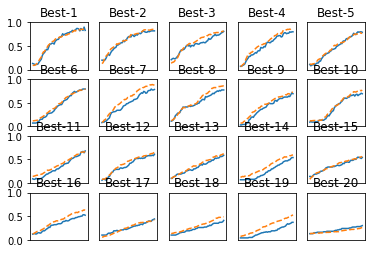

In [12]:
# coding: utf-8
import sys
import os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784,
                            hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd',
                      optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x: x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5:
        plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()